# dl_weather common language demo

## Products and Variable enumerations

In [1]:
from dl_weather.common import WeatherProducts, WeatherVars

/opt/conda/lib/python3.7/site-packages/descarteslabs/common/workflows/arrow_serialization/context.py:57: FutureWarning: 'pyarrow.SerializationContext' is deprecated and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  serialization_context = pa.SerializationContext()
/opt/conda/lib/python3.7/site-packages/descarteslabs/common/workflows/arrow_serialization/context.py:58: FutureWarning: 'pyarrow.register_default_serialization_handlers' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  pa.register_default_serialization_handlers(serialization_context)


In [2]:
list(WeatherProducts)

[<WeatherProducts.ERA5: {'description': 'ECMWF ERA5 Reanalysis Weather Product', 'product_id': 'ecmwf:era5:v0'}>,
 <WeatherProducts.CFSRV2: {'description': 'NCEP CFS-v2 Derived Daily Weather Product', 'product_id': 'ncep:cfsr-v2:daily:v1'}>]

In [3]:
list(WeatherVars)

[<WeatherVars.Precipitation: {'description': 'Total Precipitation per hour', 'output_units': 'mm/hr'}>,
 <WeatherVars.Wind10mU: {'description': 'Wind speed at 10m, U component', 'output_units': 'm/s'}>,
 <WeatherVars.Wind10mV: {'description': 'Wind speed at 10m, V component', 'output_units': 'm/s'}>,
 <WeatherVars.Temperature: {'description': 'Temperature at 2 meters height', 'output_units': 'K'}>,
 <WeatherVars.Runoff: {'description': 'Water runoff at surface level', 'output_units': 'mm'}>,
 <WeatherVars.SnowDepth: {'description': 'snow depth at the surface level', 'output_units': 'mm'}>,
 <WeatherVars.SurfacePressure: {'description': 'Surface Pressure', 'output_units': 'Pa'}>]

## Using WeatherProducts/WeatherVars with time series

#### 0. Create GeoContext

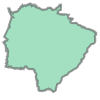

In [4]:
from dl_weather import get_weather_time_series
import descarteslabs as dl
import shapely.geometry as sg
import datetime as dt

# Get shape of state in Brazil
places_client = dl.Places()
state = places_client.shape("south-america_brazil_mato-grosso-do-sul")

# Define and simplify GeoContext
shape = sg.shape(state.geometry).simplify(0.01)
geoctx = dl.scenes.AOI(shape, crs="EPSG:4326", resolution=0.01)
shape

#### 1. Translate to DescartesLabs identifiers

In [5]:
from dl_weather.common import find_internal_product_vars

In [6]:
wprod, wvars = find_internal_product_vars(
    WeatherProducts.CFSRV2,
    [WeatherVars.SurfacePressure]
)
wprod, wvars

('ncep:cfsr-v2:daily:v1', ['surface_pressure'])

#### 2. Get weather time series

In [7]:
kwargs = {
    "geoctx": geoctx,
    "weather_product": wprod, # <---
    "weather_vars": wvars, # <---
    "weather_start": dt.datetime(2020, 1, 1),
    "weather_end": dt.datetime(2020, 1, 9),
    "frequency": "daily",
}

ts = get_weather_time_series(**kwargs)
ts

Submitting 8 jobs 



  0%|          | 0/8 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/descarteslabs/workflows/inspect/client.py:219: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  **arguments,


,surface_pressure
2020-01-01,9708.527536
2020-01-02,9715.029954
2020-01-03,9721.091175
2020-01-04,9710.106962
2020-01-05,9691.562131
2020-01-06,9701.946960
2020-01-07,9725.186505
2020-01-08,9731.722483


#### 3. Unit coversion and column name normalization

In [8]:
from dl_weather.common import apply_common_columns_and_units

In [9]:
cfsrv2_data = apply_common_columns_and_units(ts, WeatherProducts.CFSRV2)
cfsrv2_data


,SurfacePressure
2020-01-01,970.852754
2020-01-02,971.502995
2020-01-03,972.109118
2020-01-04,971.010696
2020-01-05,969.156213
2020-01-06,970.194696
2020-01-07,972.518650
2020-01-08,973.172248


### Now with ERA5

In [10]:
wprod, wvars = find_internal_product_vars(
    WeatherProducts.ERA5,
    [WeatherVars.SurfacePressure]
)

kwargs = {
    "geoctx": geoctx,
    "weather_product": wprod,
    "weather_vars": wvars,
    "weather_start": dt.datetime(2020, 1, 1),
    "weather_end": dt.datetime(2020, 1, 9),
    "frequency": "daily",
}

ts = get_weather_time_series(**kwargs)

era5_data = apply_common_columns_and_units(ts, WeatherProducts.ERA5)
era5_data

Submitting 8 jobs 



  0%|          | 0/8 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/descarteslabs/workflows/inspect/client.py:219: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  **arguments,


,SurfacePressure
2020-01-01,97194.448950
2020-01-02,97179.554713
2020-01-03,97245.209937
2020-01-04,97148.179872
2020-01-05,96975.346601
2020-01-06,96986.662744
2020-01-07,97200.814283
2020-01-08,97337.237864
